## Week 3 Assignment  
## Segmenting and Clustering Neighborhoods in Toronto

## Part 1.

In [20]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
print('Libraries imported.')

Solving environment: / 
  - anaconda/osx-64::ca-certificates-2020.1.1-0, anaconda/osx-64::certifi-2019.11.28-py37_0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_4
  - anaconda/osx-64::ca-certificates-2020.1.1-0, anaconda/osx-64::certifi-2019.11.28-py37_0, defaults/osx-64::openssl-1.1.1d-h1de35cc_4
  - anaconda/osx-64::ca-certificates-2020.1.1-0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_4, defaults/osx-64::certifi-2019.11.28-py37_0
  - anaconda/osx-64::ca-certificates-2020.1.1-0, defaults/osx-64::certifi-2019.11.28-py37_0, defaults/osx-64::openssl-1.1.1d-h1de35cc_4
  - anaconda/osx-64::openssl-1.1.1d-h1de35cc_4, defaults/osx-64::ca-certificates-2020.1.1-0, defaults/osx-64::certifi-2019.11.28-py37_0
  - defaults/osx-64::ca-certificates-2020.1.1-0, defaults/osx-64::certifi-2019.11.28-py37_0, defaults/osx-64::openssl-1.1.1d-h1de35cc_4
  - anaconda/osx-64::certifi-2019.11.28-py37_0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_4, defaults/osx-64::ca-certificates-2020.1.1-0
  - anaconda/osx-64::cer

I read data from Wiki and make a dataframe:

In [21]:
import requests
import html5lib
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfs = pd.read_html(url)
df = pd.concat(dfs)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,Borough,Neighborhood,Postal code
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not assigned,NaN,M1A
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not assigned,NaN,M2A
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,North York,Parkwoods,M3A


I make a dataframe with selected columns:

In [22]:
dff = df[['Postal code','Borough', 'Neighborhood']]

In [23]:
dff.head(3)

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods


I remove rows in __Borough__ column with "Not assigned" values:

In [24]:
df1 = dff[dff.Borough !='Not assigned']

In [25]:
df1.reset_index(drop=True, inplace=True)

In [26]:
df1.head(3)

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront


Here I replace __/__ with a __comma__:

In [27]:
df1['Neighborhood'] = df1.Neighborhood.replace({"\ /":","}, regex=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
df1['Neighborhood'] = df1.Neighborhood.replace({" ,": ","}, regex = True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Here I sort the values according to Postal code:

In [30]:
df_s = df1.sort_values('Postal code')
df_s.reset_index(drop=True, inplace = True)
df_s.head(3)

,Postal code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"


## Part 2.

In [32]:
df_geo = pd.read_csv('http://cocl.us/Geospatial_data')

In [33]:
df_geo.head(3)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711


In [34]:
df_geo1 = df_geo[['Latitude', 'Longitude']]
df_geo1.head(3)

,Latitude,Longitude
0,43.806686,-79.194353
1,43.784535,-79.160497
2,43.763573,-79.188711


I add coordinates:

In [41]:
df_m = pd.concat([df_s, df_geo1], axis = 1)

In [47]:
df_m.dropna(inplace=True)

In [376]:
df_m.shape

(103, 5)

In [538]:
df_m.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Part 3.

#### Explore neighborhoods in Toronto:

I get geografical coordinates of __Toronto__ :

In [49]:
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [539]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)
map_toronto

Visualization of __Toronto__ and its __Neighborhoods__:

In [378]:
map_toronto1 = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, label in zip(df_m['Latitude'], df_m['Longitude'], df_m['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto1)  
    
map_toronto1

#### To utilize Foursquare API and explore neighborhoods - 
#### Define Foursquare Credentials and Version

In [51]:
CLIENT_ID = 'UNZLHS2RXGLI0PVUCOT52QK415XYNF2STTXAASR3Q3UQWRK5' 
CLIENT_SECRET = '4E4UWXLYLHZEE0IJPK5LCNOAUBKW2OPRS4SO4FJK43EOPQDF' 
VERSION = '20180605' 

#### Find and explore the first Neighborhood in the dataframe:

In [379]:
df_m.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### This is the function that extracts the __category__ of the __venue__:

In [382]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Json file is cleaned and structured in pandas dataframe:

In [383]:
venues = results['response']['groups'][0]['items']    
nearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,lat,lng
0,Yasu,Japanese Restaurant,43.662837,-79.403217
1,The Dessert Kitchen,Dessert Shop,43.662823,-79.402746
2,Rasa,Restaurant,43.662757,-79.403988
3,Piano Piano,Italian Restaurant,43.662949,-79.402898
4,Almond Butterfly,Bakery,43.662836,-79.403365


Function that repeats the process for all neighborhoods in __Toronto__:

In [384]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
  
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### To get the list of __Toronto__ neighborhoods:

In [387]:
toronto_venues = getNearbyVenues(names=df_m['Neighborhood'],
                                   latitudes=df_m['Latitude'],
                                   longitudes=df_m['Longitude']
                                  )
print(toronto_venues.shape)
toronto_venues.head()

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence P

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


#### Checking dataframe's shape and content:

In [386]:
print(toronto_venues.shape)
toronto_venues.head()

(2128, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [518]:
yoga_count = toronto_venues['Venue Category'].str.count('Yoga Studio').sum()
print('There are', yoga_count, 'Yoga Studios in Toronto!')

There are 14 Yoga Studios in Toronto!


#### Let's check which vanues and how many of them exist in our dataframe:

We can see that there are only 14 Yoga Studios in Toronto. Let see at what neighborhood they are located.

In [392]:
toronto_yoga = toronto_venues[toronto_venues['Venue Category'].str.contains('Yoga')].reset_index(drop=True)

In [393]:
toronto_yoga.head(3)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Thorncliffe Park,43.705369,-79.349372,Bikram Yoga East York,43.705450,-79.351448,Yoga Studio
1,"The Danforth West, Riverdale",43.679557,-79.352188,Moksha Yoga Danforth,43.677622,-79.352116,Yoga Studio
2,Studio District,43.659526,-79.340923,Spirit Loft Yoga,43.663548,-79.341333,Yoga Studio


Let's create a __list of Neighborhoods__ with __Yoga studio__:

#### Yoga Studios are groupped by Neighborhood:

In [394]:
NB_yoga = list(toronto_yoga.Neighborhood.unique())
NB_yoga

['Thorncliffe Park',
 'The Danforth West, Riverdale',
 'Studio District',
 'North Toronto West',
 'Church and Wellesley',
 'Regent Park, Harbourfront',
 'Central Bay Street',
 'University of Toronto, Harbord',
 'Stn A PO Boxes',
 'Little Portugal, Trinity',
 'Runnymede, Swansea',
 "Queen's Park, Ontario Provincial Government",
 'Business reply mail Processing CentrE']

Now let's create a new dataframe containing only __Neighborhoods without Yoga Studios__:

In [395]:
NB_without_yoga = toronto_venues[~toronto_venues["Neighborhood"].isin(NB_yoga)]
print("There are", len(NB_without_yoga.Neighborhood.unique()), "neigborhoods without Yoga Studio!")

There are 82 neigborhoods without Yoga Studio!


In [500]:
list_NB_woyoga = list(NB_without_yoga.Neighborhood.unique())
print(len(list_NB_woyoga))

82


In [397]:
NB_without_yoga.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


We want to choose relatively calm neighborhoods. To do so, from the list of neighborhoods without Yoga Studio we will select neighborhoods with restautants and then choose neighborhoods that are not very crouded with this type of venue. 

In [412]:
NB_without_yogaR = NB_without_yoga[NB_without_yoga["Venue Category"].str.contains('Restaurant')]
NB_without_yogaR.shape

(347, 7)

#### Let's see where the Neighborhoods withot yoga studios are located:

In [399]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, label in zip(NB_without_yogaR['Neighborhood Latitude'], NB_without_yogaR['Neighborhood Longitude'], NB_without_yogaR['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Clustering Neighborhoods with K-Means

#### Firstly, lets transform our data to dummy variables:

In [414]:
# one hot encoding
toronto_onehotY = pd.get_dummies(NB_without_yogaR[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehotY['Neighborhood'] = NB_without_yogaR['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehotY.columns[-1]] + list(toronto_onehotY.columns[:-1])
toronto_onehotY = toronto_onehotY[fixed_columns]

toronto_onehotY = toronto_onehotY[ ['Neighborhood'] + [ col for col in toronto_onehotY.columns if col != 'Neighborhood' ] ]
toronto_onehotY.drop(['Restaurant'], axis = 1, inplace=True)
toronto_onehotY.head()


,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
11,Woburn,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,Cedarbrae,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,Cedarbrae,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's group Neighborhoods by __frequency of the venue__:

In [415]:
venues_groupedY = toronto_onehotY.groupby('Neighborhood').mean().reset_index()
venues_groupedY.head(3) 

,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
2,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [416]:
venues_groupedY.shape

(52, 45)

In [402]:
venues_groupedY['Neighborhood']

0                                             Agincourt
1       Bathurst Manor, Wilson Heights, Downsview North
2                                       Bayview Village
3                     Bedford Park, Lawrence Manor East
4                                           Berczy Park
5          Brockton, Parkdale Village, Exhibition Place
6                 Canada Post Gateway Processing Centre
7                                             Cedarbrae
8                                              Christie
9               Clarks Corners, Tam O'Shanter, Sullivan
10      Cliffside, Cliffcrest, Scarborough Village West
11                       Commerce Court, Victoria Hotel
12                                           Davisville
13     Del Ray, Mount Dennis, Keelsdale and Silverthorn
14                                            Don Mills
15    Dorset Park, Wexford Heights, Scarborough Town...
16                         Dufferin, Dovercourt Village
17                         Fairview, Henry Farm,

In [410]:
RY_NB = list(venues_groupedY['Neighborhood']) 
print(len(RY_NB))

52


Clustering Neighborhoods __without Yoga__ with K-Means:

In [471]:
kclusters = 10
venues_grouped_clusteringRY = venues_groupedY.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(venues_grouped_clusteringRY)
kmeans.labels_ # 52 labels

array([0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 5, 3, 0, 0, 0, 8,
       0, 0, 0, 1, 0, 3, 0, 6, 9, 0, 7, 7, 0, 3, 0, 0, 7, 0, 7, 0, 0, 3,
       0, 0, 0, 0, 5, 5, 0, 2], dtype=int32)

In [477]:
toronto_data_NB = df_m[['Neighborhood', 'Longitude', 'Latitude']]
toronto_data_NB_without_yoga = toronto_data_NB[toronto_data_NB["Neighborhood"].isin(RY_NB)]

In [480]:
toronto_data_NB_without_yoga.sort_values(by=['Neighborhood'], inplace=True)
toronto_data_NB_without_yoga['Neighborhood'].reset_index(drop=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0                                             Agincourt
1       Bathurst Manor, Wilson Heights, Downsview North
2                                       Bayview Village
3                     Bedford Park, Lawrence Manor East
4                                           Berczy Park
5          Brockton, Parkdale Village, Exhibition Place
6                 Canada Post Gateway Processing Centre
7                                             Cedarbrae
8                                              Christie
9               Clarks Corners, Tam O'Shanter, Sullivan
10      Cliffside, Cliffcrest, Scarborough Village West
11                       Commerce Court, Victoria Hotel
12                                           Davisville
13     Del Ray, Mount Dennis, Keelsdale and Silverthorn
14                                            Don Mills
15                                            Don Mills
16    Dorset Park, Wexford Heights, Scarborough Town...
17                         Dufferin, Dovercourt 

In [499]:
toronto_data_NB_without_yoga1 = toronto_data_NB_without_yoga.drop([26, 24])

In [486]:
toronto_data_NB_without_yoga1.reset_index(drop=True)

,Neighborhood,Longitude,Latitude
0,Agincourt,-79.262029,43.794200
1,"Bathurst Manor, Wilson Heights, Downsview North",-79.442259,43.754328
2,Bayview Village,-79.385975,43.786947
3,"Bedford Park, Lawrence Manor East",-79.419750,43.733283
4,Berczy Park,-79.373306,43.644771
5,"Brockton, Parkdale Village, Exhibition Place",-79.428191,43.636847
6,Canada Post Gateway Processing Centre,-79.615819,43.636966
7,Cedarbrae,-79.239476,43.773136
8,Christie,-79.422564,43.669542
9,"Clarks Corners, Tam O'Shanter, Sullivan",-79.304302,43.781638


Let's add cluster labels to our Neighborhoods:

In [487]:
toronto_data_NB_without_yoga1.insert(0, 'Cluster Labels', kmeans.labels_)

In [489]:
toronto_data_NB_without_yoga1.reset_index(drop=True)

,Cluster Labels,Neighborhood,Longitude,Latitude
0,0,Agincourt,-79.262029,43.794200
1,0,"Bathurst Manor, Wilson Heights, Downsview North",-79.442259,43.754328
2,8,Bayview Village,-79.385975,43.786947
3,0,"Bedford Park, Lawrence Manor East",-79.419750,43.733283
4,0,Berczy Park,-79.373306,43.644771
5,0,"Brockton, Parkdale Village, Exhibition Place",-79.428191,43.636847
6,0,Canada Post Gateway Processing Centre,-79.615819,43.636966
7,0,Cedarbrae,-79.239476,43.773136
8,0,Christie,-79.422564,43.669542
9,0,"Clarks Corners, Tam O'Shanter, Sullivan",-79.304302,43.781638


### Lets put clusters on the map:

In [490]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_data_NB_without_yoga1['Latitude'], toronto_data_NB_without_yoga1['Longitude'], toronto_data_NB_without_yoga1['Neighborhood'], toronto_data_NB_without_yoga1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Exploring Clusters:

Let's count how many neighborhoods are found in each cluster.

In [491]:
toronto_data_NB_without_yoga1.groupby('Cluster Labels').count()['Neighborhood']

Cluster Labels
0    33
1     1
2     1
3     5
4     1
5     3
6     1
7     4
8     2
9     1
Name: Neighborhood, dtype: int64

In [492]:
venues_groupedY.insert(0, 'Cluster Labels', kmeans.labels_)

In [493]:
venues_groupedY.head(3)

,Cluster Labels,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
2,8,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [541]:
venues_clustered = venues_groupedY.groupby('Cluster Labels').mean()
venues_clustered

,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.049877,0.014875,0.003211,0.002222,0.004329,0.047854,0.025478,0.002222,0.007986,0.007576,0.00303,0.001894,0.001894,0.009596,0.030303,0.001318,0.02142,0.001894,0.020622,0.001318,0.004355,0.010274,0.010101,0.033705,0.002525,0.09703,0.035399,0.0,0.032525,0.012323,0.059399,0.035573,0.00253,0.002635,0.008003,0.017172,0.010211,0.025543,0.080518,0.002525,0.050069,0.0,0.022397,0.024676
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.270000,0.020000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.31000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04000,0.040000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.050000,0.040000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.833333,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [495]:
venues_clustered_trans = venues_clustered.transpose()

In [498]:
venues_clustered_trans.head() 

Cluster Labels,0,1,2,3,4,5,6,7,8,9
American Restaurant,0.049877,0.0,0.0,0.27,0.0,0.0,0.0,0.0,0.0,0.0
Asian Restaurant,0.014875,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0
Belgian Restaurant,0.003211,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Brazilian Restaurant,0.002222,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Cajun / Creole Restaurant,0.004329,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


Let's present this data frame as a heatmap:

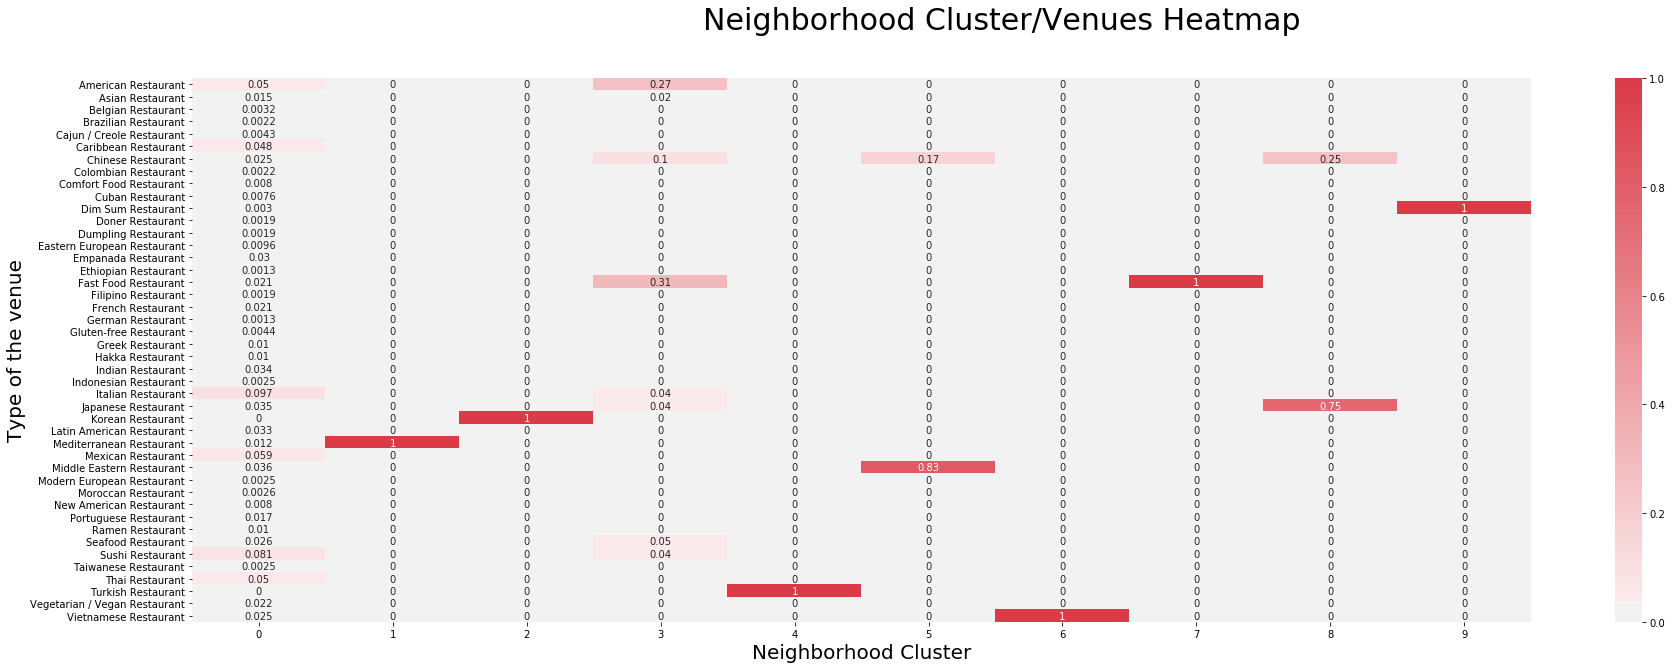

In [497]:
fig, ax = plt.subplots(figsize=(30,10))

ax = sns.heatmap(venues_clustered_trans, center=0, annot=True, ax=ax, cmap=sns.diverging_palette(220, 10, as_cmap=True))

fig.suptitle('Neighborhood Cluster/Venues Heatmap', fontsize=30)
plt.xlabel('Neighborhood Cluster', fontsize=20)
plt.ylabel('Type of the venue', fontsize=20)

plt.show()



#### From the heatmap we can see that neighborhoods in 0 Cluster are very crowded with restaurants. 

#### So it is better to choose neighborhoods in other clusters (1-9). Here is the list of these neighborhoods:

In [543]:
filter_avoid = venues_groupedY['Cluster Labels'].isin([0])
NB_avoid = venues_groupedY.loc[filter_avoid]
NB_avoid.reset_index(drop=True, inplace=True)
NB_avoid['Neighborhood']

0                                             Agincourt
1       Bathurst Manor, Wilson Heights, Downsview North
2                     Bedford Park, Lawrence Manor East
3                                           Berczy Park
4          Brockton, Parkdale Village, Exhibition Place
5                 Canada Post Gateway Processing Centre
6                                             Cedarbrae
7                                              Christie
8               Clarks Corners, Tam O'Shanter, Sullivan
9                        Commerce Court, Victoria Hotel
10                                           Davisville
11                                            Don Mills
12    Dorset Park, Wexford Heights, Scarborough Town...
13               First Canadian Place, Underground city
14                             Forest Hill North & West
15                             Garden District, Ryerson
16                    Guildwood, Morningside, West Hill
17    Harbourfront East, Union Station, Toronto 

In [532]:
filter_clusters = venues_groupedY['Cluster Labels'].isin(range(1,10))

In [537]:
final_data = venues_groupedY.loc[filter_clusters]
final_data.reset_index(drop=True, inplace=True)
final_data['Neighborhood']

0                                       Bayview Village
1       Cliffside, Cliffcrest, Scarborough Village West
2      Del Ray, Mount Dennis, Keelsdale and Silverthorn
3                          Dufferin, Dovercourt Village
4                          Fairview, Henry Farm, Oriole
5                                             Glencairn
6                                     Hillcrest Village
7                        India Bazaar, The Beaches West
8                      Lawrence Manor, Lawrence Heights
9                                         Lawrence Park
10                                       Malvern, Rouge
11    Mimico NW, The Queensway West, South of Bloor,...
12         New Toronto, Mimico South, Humber Bay Shores
13                      Parkview Hill, Woodbine Gardens
14    South Steeles, Silverstone, Humbergate, Jamest...
15                        Steeles West, L'Amoreaux West
16                                            Westmount
17                                    Wexford, M

In [544]:
NB_to_choose = list(final_data['Neighborhood'])

In [ ]:
 toronto_data_NB_without_yoga = toronto_data_NB[toronto_data_NB["Neighborhood"].isin(RY_NB)]
    NB_without_yoga

In [546]:
to_consider = NB_without_yoga[NB_without_yoga['Neighborhood'].isin(NB_to_choose)]


In [550]:
to_consider

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
9,Woburn,43.770992,-79.216917,Starbucks,43.770037,-79.221156,Coffee Shop
10,Woburn,43.770992,-79.216917,Tim Hortons,43.770827,-79.223078,Coffee Shop
11,Woburn,43.770992,-79.216917,Korean Grill House,43.770812,-79.214502,Korean Restaurant
12,Woburn,43.770992,-79.216917,Jessies Variety Store,43.772778,-79.222500,Convenience Store
39,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,Have A Nap Motel,43.718256,-79.240135,Motel
40,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,Vincent's Spot,43.717002,-79.242353,American Restaurant
50,"Wexford, Maryvale",43.750072,-79.295849,Crown Pastries,43.746098,-79.293142,Bakery
51,"Wexford, Maryvale",43.750072,-79.295849,Wexford Restaurant,43.746030,-79.293843,Breakfast Spot
52,"Wexford, Maryvale",43.750072,-79.295849,Subway,43.746267,-79.293193,Sandwich Place


In [584]:
venues_list = pd.DataFrame(to_consider['Venue Category'].value_counts())
venues_list.reset_index(inplace=True)
venues_list
venues_list.rename(columns = {'index': 'Venue', 'Venue Category': 'Count'}, inplace=True)
venues_list.shape

(88, 2)

Let's remove vuenues that are counted only on time across all neighborhoods.

In [582]:
venues_list2 = venues_list[venues_list['Count'] >= 2]

In [597]:
venues_list2.set_index(venues_list2['Venue'], drop=True, inplace=True)

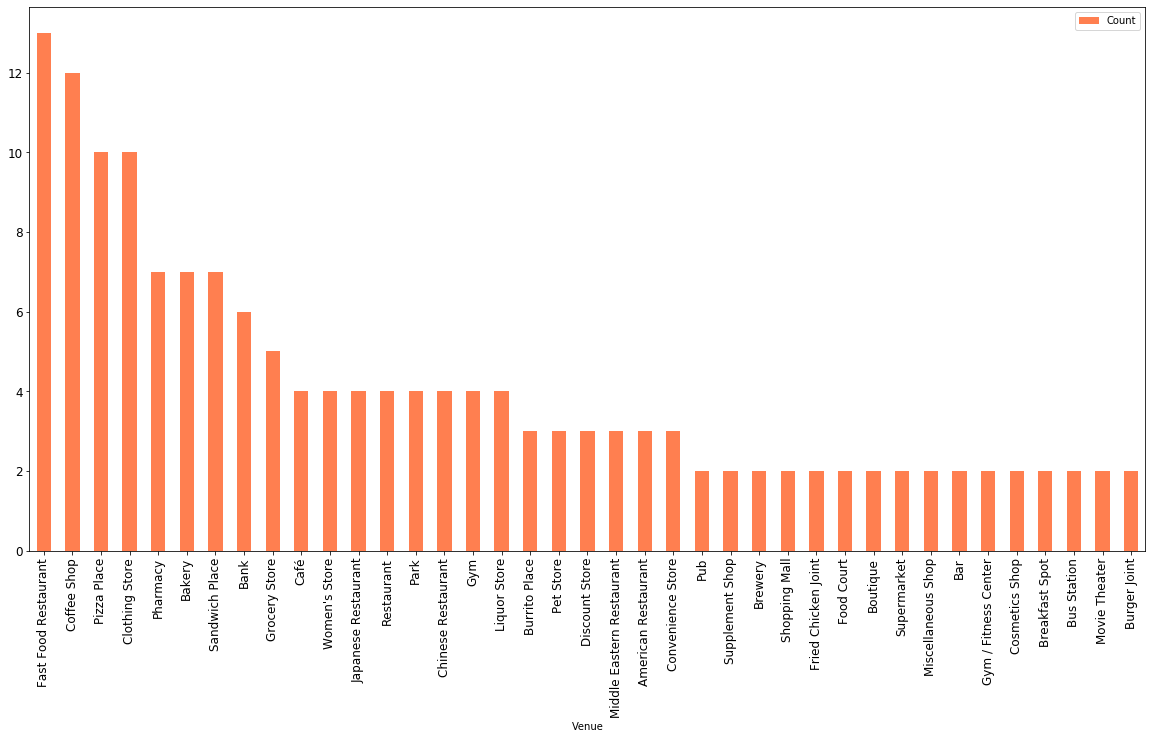

In [634]:
venues_list2.plot.bar( figsize= (20,10), fontsize=12, color = 'coral')


Finally, lets put selected neighborhoods on the map:

In [628]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(to_consider['Neighborhood Latitude'], to_consider['Neighborhood Longitude'], to_consider['Neighborhood']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
        
       
map_clusters